In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
data = yf.download(tickers='^SPX', start = '2024-01-01', interval = '1h')


In [ ]:
plt.plot(data['Close'],
         scalex=True,
         scaley= True,)

In [68]:
df = pd.DataFrame(data, columns=['Close'])
closing_prices = df['Close']

The formula for an Exponential Moving average is: $$\text{EMA}_{\text{today}} = P_{\text{today}} \times K + \text{EMA}_{\text{Yesterday}} \times (1-K)
                    $$
                
            
where K is the smoothing Factor $$k = \frac{2}{N+1}$$

In [ ]:
print(closing_prices)

In [70]:
# short term EMA 11 days as adviced by Dr Alexander Elder in his book 

def calculate_ema(prices, n):
    k = 2 / (n+1)

    def calculate_sma(priceseries, n):
        return sum(priceseries[:n]) / n 
    # prices[:n] follows the format list[start:stop] slicing

    initial_ema = calculate_sma(prices, n)

    ema_values = [None] * (n-1)
    ema_values.append(initial_ema)

    for i in range(n, len(prices)):
        price_today = prices[i]
        ema_yesterday = ema_values[-1] # [-1] accesses the element at the end of the list
        ema_today = (price_today * k) + (ema_yesterday * (1 - k))
        ema_values.append(ema_today)

    ema_series = pd.Series(ema_values, index = prices.index)

    result_df = pd.DataFrame(prices)
    result_df['EMA'] = ema_series

    return result_df


    




In [ ]:
ema11_result = calculate_ema(closing_prices, 11)

In [ ]:
ema22_result = calculate_ema(closing_prices, 22)

In [ ]:
plt.figure(figsize=(18, 12))
plt.plot(closing_prices, color = 'black', label = 'Close Price')
plt.plot(closing_prices.index, ema11_result['EMA'], color = 'blue', label = 'EMA 11')
plt.plot(closing_prices.index, ema22_result['EMA'], color = 'red', label = 'EMA 22')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Closing Prices and EMA 11|22')
plt.legend()
plt.grid(True)
plt.show()


So far I have calculated the Exponential moving average for both 11 and 22 days and been able to visualise this graphically. Now I need to set up trading signals to allow opening of positions. Only long positions will be opened.


In [74]:
ema11_series = ema11_result['EMA'].rename('EMA 11')
ema22_series = ema22_result['EMA'].rename('EMA 22')

merged_dataframe = pd.concat([
    closing_prices,
    ema11_series,
    ema22_series],
    axis = 1
)


In [75]:
merged_dataframe['Signal'] = (merged_dataframe['EMA 11'] > merged_dataframe['EMA 22']).astype(int)


In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (16,10), sharex = True)

ax1.plot(merged_dataframe['Close'], color = 'black', label = 'Close Price')
ax1.plot(merged_dataframe['EMA 11'], color = 'blue', label = 'EMA 11')
ax1.plot(merged_dataframe['EMA 22'], color = 'red', label = 'EMA 22')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.set_title('Closing Prices and EMA 11|22')
ax1.legend()
ax1.grid(True)

ax2.plot(merged_dataframe.index, merged_dataframe['Signal'], color = 'purple', label = 'Signal')
ax2.set_xlabel('Date')
ax2.set_ylabel('Signal')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()



Note that each EMA has not been lagged by a third of its length which is the correct way of plotting the moving average.

In [77]:
merged_dataframe['position'] = np.where(merged_dataframe['EMA 11'] > merged_dataframe['EMA 22'], 1, -1)

In [78]:
merged_dataframe['Signal'] = (merged_dataframe['EMA 11'] > merged_dataframe['EMA 22']).astype(int)

Both of the lines of code above are vectorised options in Pandas and NumPy meaning they are faster and more efficient than the following if-else loop over each row of a DataFrame

In [79]:
for i in range(len(merged_dataframe)):
    if merged_dataframe.iloc[i]['EMA 11'] > merged_dataframe.iloc[i]['EMA 22']:
         merged_dataframe.at[merged_dataframe.index[i], 'position'] = 1
    else:
        merged_dataframe.at[merged_dataframe.index[i], 'position'] = 0

In [80]:
merged_dataframe['buy_price'] = np.nan
merged_dataframe['return'] = np.nan

In [81]:
buy_price=np.nan

In [ ]:
%timeit -r 1000 -n 1000 merged_dataframe['buy_price'] = np.nan
merged_dataframe['buy_price'] = np.nan
merged_dataframe['return'] = np.nan

buy_price = np.nan

for i in range(1, len(merged_dataframe)):
    if merged_dataframe.iloc[i]['Signal'] == 1 and merged_dataframe.iloc[i-1]['Signal'] != 1:
        buy_price = merged_dataframe.iloc[i]['Close']
        merged_dataframe.iloc[i, merged_dataframe.columns.get_loc('buy_price')] = buy_price
    
    elif merged_dataframe.iloc[i]['Signal'] == 0 and merged_dataframe.iloc[i-1]['Signal'] == 1:
        sell_price = merged_dataframe.iloc[i]['Close']
        merged_dataframe.iloc[i, merged_dataframe.columns.get_loc('return')] = (sell_price - buy_price) / buy_price
        buy_price = np.nan 
    
    elif merged_dataframe.iloc[i]['Signal'] == 1:
        merged_dataframe.iloc[i, merged_dataframe.columns.get_loc('buy_price')] = buy_price

merged_dataframe['buy_price'] = merged_dataframe['buy_price'].ffill()

The above code uses a for loop to iterate through each row of the DataFrame to determine prices at which the asset is bought and sold based on signals. Whilst this approach is straighforward it is slower than vectorised operations using Pandas, which is ptimized for vectorized operations that apply functions to entire arrays at once. We can see this by recording the computational time of each block.

In [ ]:
%timeit -r 1000 -n 1000 merged_dataframe['buy_price'] = np.nan
merged_dataframe['buy_price'] = np.where(
    (merged_dataframe['Signal'] == 1) & (merged_dataframe['Signal'].shift(1) != 1),
    merged_dataframe['Close'],
    np.nan
)
# Buy condition Signal becomes 1 when previous observation signal was not 1.

merged_dataframe['buy_price'] = merged_dataframe['buy_price'].ffill()

merged_dataframe['return'] = np.where(
    (merged_dataframe['Signal'] == 0) & (merged_dataframe['Signal'].shift(1) == 1),
    (merged_dataframe['Close'] - merged_dataframe['buy_price']) / merged_dataframe['buy_price'],
    np.nan
)

merged_dataframe['buy_price'] = np.where(
    (merged_dataframe['Signal'] == 0) & (merged_dataframe['Signal'].shift(1) != 1),
    np.nan,
    merged_dataframe['buy_price']
)


In [42]:
merged_dataframe['return'] = merged_dataframe['return'].fillna(0)


In [55]:
initial_investment = 1

merged_dataframe['Cumulative Value'] = initial_investment * (1 +merged_dataframe['return']).cumprod().ffill()



In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(merged_dataframe.index, merged_dataframe['Cumulative Value'], label='Cumulative Value (£1 Investment)', color='blue')
plt.title('Cumulative Value of Investment Over Time')
plt.xlabel('Date')
plt.ylabel('Value (£)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

In [ ]:
final_value = merged_dataframe['Cumulative Value'].iloc[-1]
final_return = final_value - initial_investment
percentage_return = (final_return / initial_investment) * 100

print(f"Initial Investment : £{initial_investment:.2f}")
print(f"Final_Value: £{final_value:.2f}")
print(f"Return: £{final_return:.2f}")
print(f"Percentage Return: {percentage_return:.2f}%")

Whilst we can backtest in procedural program form, despite the EMA for-loop being less efficient than a vectorised operation, it is better to create a backtesting class, and use OOP.




In [3]:
# BACKTESTING CLASS For EMA Strategy

class Backtest:

    def __init__(self, symbol): # Constructor Method - purpose is to initialize objects attributes #constructor method = __init__() # self refers to instance being created 
        self.symbol = symbol # attribute
        self.df = yf.download(self.symbol, start = '2023-01-01')
        if self.df.empty:
            print('No data pulled')
        else: # need to call methods in the Constructor
            self.calc_indicators()
            self.generate_signals()
            self.position_filter()
            self.profit = self.calc_profit()
            self.cum_profit = (self.profit + 1).prod() - 1

    def calc_indicators(self): # First method for calculating technical indicators N.B a method is a function that is associated with an object and can operate on the data contained in the object(Class)
        self.df['ema_11'] = self.df.Close.ewm(span = 11, adjust = False).mean()
        self.df['ema_22'] = self.df.Close.ewm(span = 22, adjust = False).mean()
        self.df.dropna(inplace=True) # arg defines wether to modify the DataFrame in place or to return a new DataFrame in this case to return a new DF

    def generate_signals(self): 
        conditions = [(self.df.ema_11 > self.df.ema_22) ,(self.df.ema_11 <= self.df.ema_22)]
        choices = [1,0] 
        default = 0
        self.df['signal'] = np.select(conditions, choices, default=default)
        self.df.signal = self.df.signal.shift() # We want to access buy price on next days open 
        self.df.dropna(inplace=True)
    
    def position_filter(self): # filter to make sure only one position is held at any one time
        position = False
        buydates, selldates = [] , []

        for index, row in self.df.iterrows(): # n.b for loop could be faster as a vectorized operation
            if not position and row['signal'] == 1:
                position = True
                buydates.append(index)

            if position and row['signal'] == 0: # if position is true and row signal which is shifted down by one row
                position = False
                selldates.append(index)
        
        self.buy_arr = self.df.loc[buydates].Open
        self.sell_arr = self.df.loc[selldates].Open
        
    def calc_profit(self): # considers open trade at end of backtest , cannot calc profit only unrealised profit, filter open trades out
        if self.buy_arr.index[-1] > self.sell_arr.index[-1]:
            self.buy_arr = self.buy_arr[:-1] # if there is a buy date after last sell i.e open position we dont account for this
        return(self.sell_arr.values - self.buy_arr.values)/self.buy_arr.values # pct returns
    
    def plot_chart(self):
        plt.figure(figsize=(16,8))
        plt.plot(self.df.Close, color = 'black')
        plt.plot(self.df.ema_11, color = 'blue', label = 'EMA 11')
        plt.plot(self.df.ema_22, color = 'orange', label = 'EMA 22')
        plt.scatter(self.buy_arr.index, self.buy_arr.values, marker='^', c = 'g', label='Buy', s = 175)
        plt.scatter(self.sell_arr.index, self.sell_arr.values, marker='v', c = 'r', label = 'Sell', s = 175)
        plt.xlabel('Date')
        plt.ylabel('Closing Price')
        plt.title(f'EMA Cross Over Strategy for {self.symbol}')
        plt.grid()
        plt.legend()







# N.B arguments are values passed to a function when it is called. These are values used by the function to perform its operations. Types of argumetns: positional = values assigned to parameters based on their position
# Keyword arguments = name = 'George' you explicitly define which value goes to which parameter
# Default arguments; if no arg is passed for them when the function is called, the default value is used
# Variable Length arguments *args allows a variable number of arguments to be passed such as a tuple eg. def add_number(*args):    input = add_number(1,2,3)

        



In [4]:
instance = Backtest('INTC') # this is an instance of our Backtest class, we have accessed the attribute of out backtest class and given it as the ticker ^SPX

NameError: name 'yf' is not defined

In [234]:
intc = instance.df # We have accessed the df attribute of our person class

In [177]:
instance.buy_arr

Date
2023-01-05    3839.739990
2023-03-31    4056.179932
2023-09-01    4530.600098
2023-11-08    4384.370117
2024-05-08    5168.979980
2024-08-19    5557.229980
Name: Open, dtype: float64

In [178]:
instance.sell_arr

Date
2023-02-27    3992.360107
2023-08-16    4433.790039
2023-09-20    4452.810059
2024-04-16    5064.589844
2024-07-29    5476.549805
Name: Open, dtype: float64

In [237]:
instance.profit

array([ 0.01567056,  0.01268054, -0.01335504,  0.02643312, -0.0461023 ,
       -0.04261209,  0.16205418, -0.08591727, -0.06600056])

In [1]:
instance.cum_profit


NameError: name 'instance' is not defined

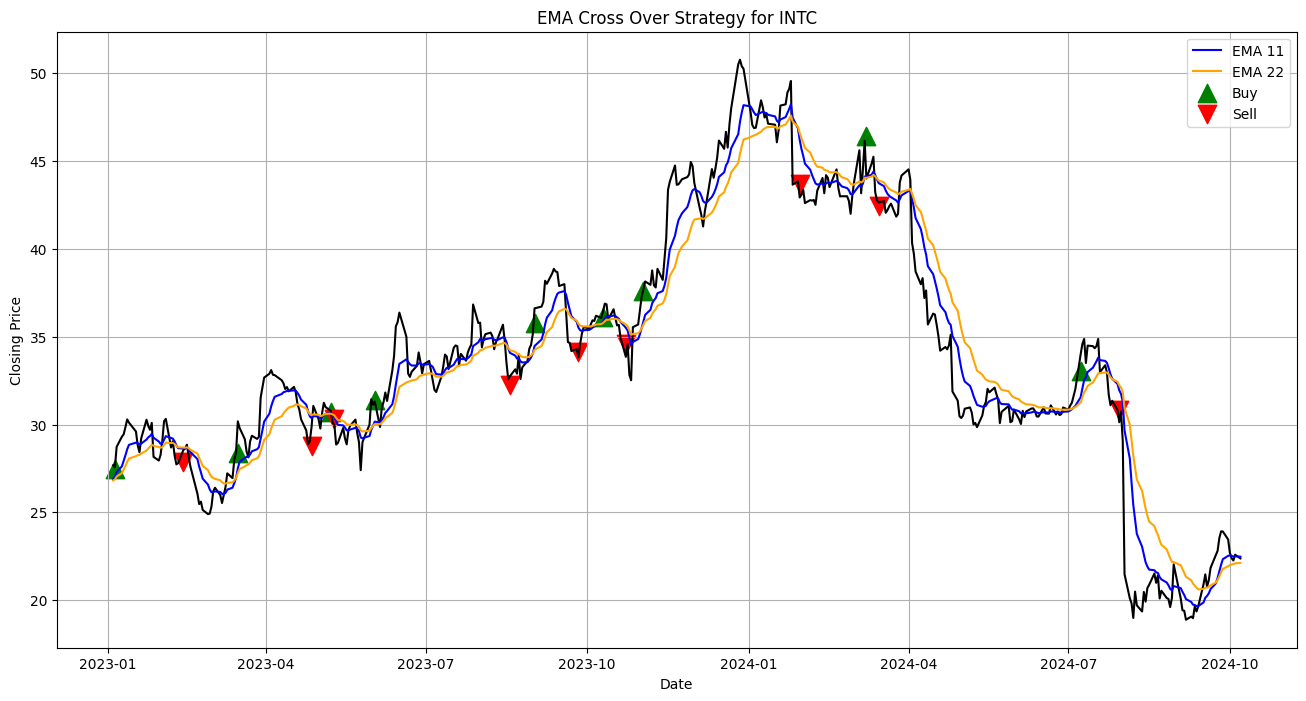

In [235]:
instance.plot_chart()

This is a Object-Oriented approach to backtesting. The advantages of this versus the prior procedural program where each aspect of the backtesting process is handled seperately; is the readability, structure and reproducibility. 

# Now use python for algorithmic trading to find a more efficient backtesting class
